Device: cuda
GPU: NVIDIA GeForce GTX 1050 Ti
trainA images: 1067
trainB images: 1334
Sample batch shapes: torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])
Epoch 1/20 | iter 100/1334 | G=6.52 | D_A=0.26 | D_B=0.24
Epoch 1/20 | iter 200/1334 | G=11.91 | D_A=0.18 | D_B=0.28
Epoch 1/20 | iter 300/1334 | G=6.65 | D_A=0.28 | D_B=0.23
Epoch 1/20 | iter 400/1334 | G=9.02 | D_A=0.39 | D_B=0.26
Epoch 1/20 | iter 500/1334 | G=6.86 | D_A=0.18 | D_B=0.21
Epoch 1/20 | iter 600/1334 | G=6.93 | D_A=0.13 | D_B=0.33
Epoch 1/20 | iter 700/1334 | G=9.51 | D_A=0.13 | D_B=0.27
Epoch 1/20 | iter 800/1334 | G=6.12 | D_A=0.35 | D_B=0.25
Epoch 1/20 | iter 900/1334 | G=6.82 | D_A=0.05 | D_B=0.12
Epoch 1/20 | iter 1000/1334 | G=9.24 | D_A=0.15 | D_B=0.15
Epoch 1/20 | iter 1100/1334 | G=8.12 | D_A=0.11 | D_B=0.08
Epoch 1/20 | iter 1200/1334 | G=6.32 | D_A=0.16 | D_B=0.19
Epoch 1/20 | iter 1300/1334 | G=7.28 | D_A=0.17 | D_B=0.12

Epoch 001 finished in 501.6s | G=8.212 | D_A=0.251 | D_B=0.234 | cycle=5.078

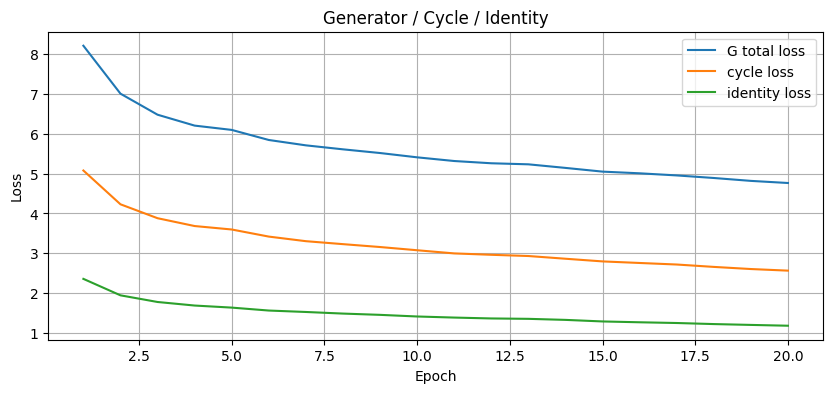

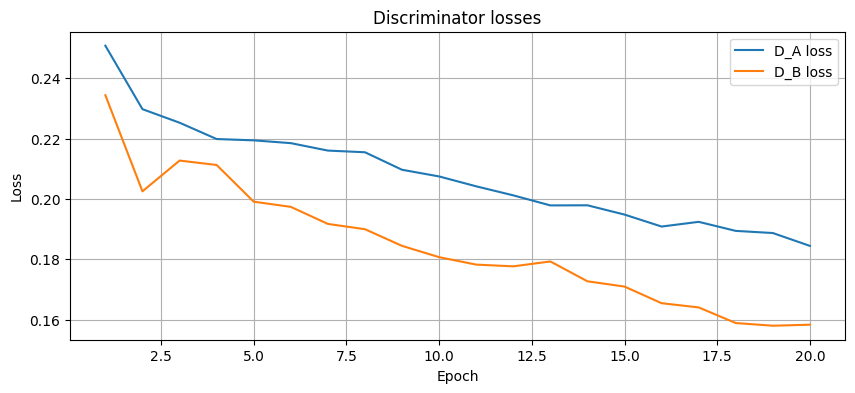

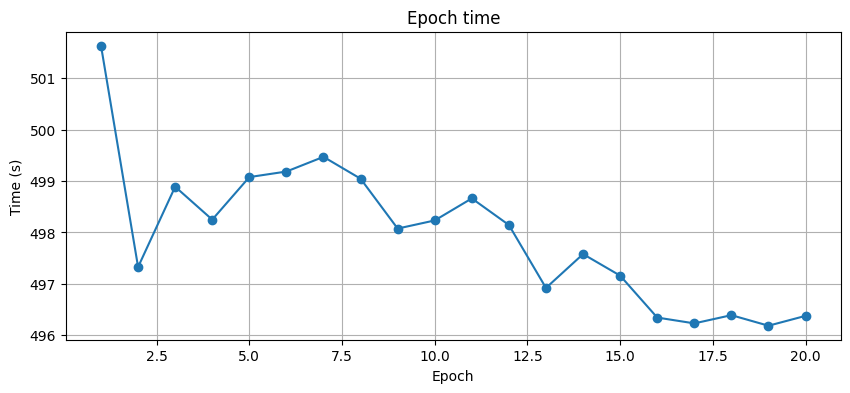

Sample A: C:/Users/Master Arian/Desktop/DGM2/horse2zebra\trainA\n02381460_998.jpg
Sample B: C:/Users/Master Arian/Desktop/DGM2/horse2zebra\trainB\n02391049_2258.jpg


C:\Users\Master Arian\AppData\Local\Temp\ipykernel_5744\2087205880.py:388: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(f"G_{direction}_epoch{e

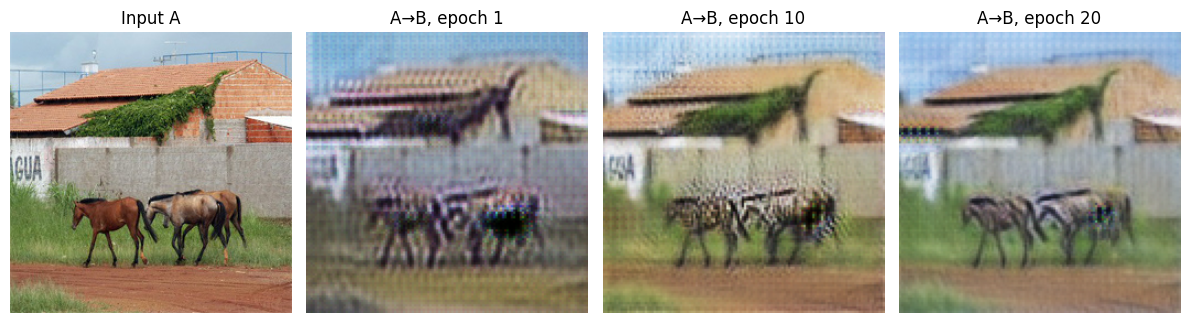

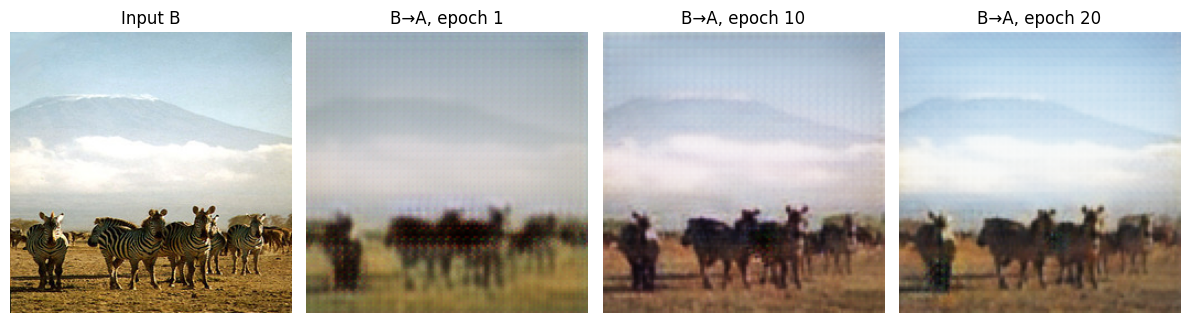

In [1]:
# ==============================
#   CycleGAN full pipeline
#   Dataset + Models + Training + Plots + Sampling
# ==============================
import os
import time
import random
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# --------------------
# Device
# --------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

# --------------------
# Paths (adjust if needed)
# --------------------
root = r"C:/Users/Master Arian/Desktop/DGM2/horse2zebra"
trainA = os.path.join(root, "trainA")
trainB = os.path.join(root, "trainB")

print("trainA images:", len(os.listdir(trainA)))
print("trainB images:", len(os.listdir(trainB)))

# ======================================================
# 1) Dataset & Dataloader
# ======================================================
class CycleGANDataset(Dataset):
    def __init__(self, folderA, folderB, transform=None):
        self.A_paths = sorted([os.path.join(folderA, f) for f in os.listdir(folderA)])
        self.B_paths = sorted([os.path.join(folderB, f) for f in os.listdir(folderB)])
        self.transform = transform
        self.length = max(len(self.A_paths), len(self.B_paths))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        A_path = self.A_paths[idx % len(self.A_paths)]
        B_path = self.B_paths[idx % len(self.B_paths)]

        imgA = Image.open(A_path).convert("RGB")
        imgB = Image.open(B_path).convert("RGB")

        if self.transform is not None:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)

        return imgA, imgB

# transforms (128x128, normalized to [-1,1])
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds = CycleGANDataset(trainA, trainB, transform=transform)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

# quick check
A_sample, B_sample = next(iter(train_loader))
print("Sample batch shapes:", A_sample.shape, B_sample.shape)

# Optional: show some samples
def show_samples(folderA, folderB, n=3):
    filesA = [os.path.join(folderA, f) for f in os.listdir(folderA)]
    filesB = [os.path.join(folderB, f) for f in os.listdir(folderB)]
    plt.figure(figsize=(3*n, 4))
    for i in range(n):
        imgA = Image.open(random.choice(filesA)).convert("RGB")
        imgB = Image.open(random.choice(filesB)).convert("RGB")
        plt.subplot(2, n, i+1)
        plt.imshow(imgA)
        plt.axis("off")
        plt.title("A sample")
        plt.subplot(2, n, n+i+1)
        plt.imshow(imgB)
        plt.axis("off")
        plt.title("B sample")
    plt.tight_layout()
    plt.show()

# show_samples(trainA, trainB)  # اگر خواستی ببینی کامنت رو بردار


# ======================================================
# 2) Models (Generator & Discriminator)
# ======================================================
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):

    def __init__(self, in_c=3, out_c=3, n_res=6):
        super().__init__()
        layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_c, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True)
        ]

        dim = 64
        # downsampling
        for _ in range(2):
            layers += [
                nn.Conv2d(dim, dim*2, 3, stride=2, padding=1),
                nn.InstanceNorm2d(dim*2),
                nn.ReLU(True)
            ]
            dim *= 2

        # residual blocks
        for _ in range(n_res):
            layers += [ResBlock(dim)]

        # upsampling
        for _ in range(2):
            layers += [
                nn.ConvTranspose2d(dim, dim//2, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(dim//2),
                nn.ReLU(True)
            ]
            dim //= 2

        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(dim, out_c, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    """
    PatchGAN discriminator (70x70)
    """
    def __init__(self, in_c=3):
        super().__init__()
        def block(in_f, out_f, norm=True):
            layers = [nn.Conv2d(in_f, out_f, 4, stride=2, padding=1)]
            if norm:
                layers.append(nn.InstanceNorm2d(out_f))
            layers.append(nn.LeakyReLU(0.2, True))
            return layers

        self.model = nn.Sequential(
            *block(in_c, 64, norm=False),
            *block(64, 128),
            *block(128, 256),
            nn.Conv2d(256, 1, 4, padding=1)   # output patch map
        )

    def forward(self, x):
        return self.model(x)


# instantiate models
G_AB = Generator().to(device)  # A -> B
G_BA = Generator().to(device)  # B -> A
D_A  = Discriminator().to(device)
D_B  = Discriminator().to(device)

# weight init
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

for net in [G_AB, G_BA, D_A, D_B]:
    net.apply(init_weights)

# ======================================================
# 3) Losses & Optimizers
# ======================================================
criterion_GAN   = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_id    = nn.L1Loss()

lambda_cycle = 10.0
lambda_id    = 5.0

optimizer_G  = torch.optim.Adam(
    list(G_AB.parameters()) + list(G_BA.parameters()),
    lr=2e-4, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=2e-4, betas=(0.5, 0.999))

def denorm(x):
    # از [-1,1] به [0,1]
    return (x * 0.5 + 0.5).clamp(0, 1)

# ======================================================
# 4) Training Loop (with timing + saving checkpoints)
# ======================================================
num_epochs = 20

epoch_times = []
G_losses    = []
D_A_losses  = []
D_B_losses  = []
cycle_losses = []
id_losses    = []

for epoch in range(1, num_epochs+1):

    start = time.time()

    G_loss_e = 0.0
    D_A_loss_e = 0.0
    D_B_loss_e = 0.0
    cycle_loss_e = 0.0
    id_loss_e = 0.0

    G_AB.train()
    G_BA.train()
    D_A.train()
    D_B.train()

    for i, (real_A, real_B) in enumerate(train_loader):

        real_A = real_A.to(device)
        real_B = real_B.to(device)

        # ------------------ Train Generators ------------------ #
        optimizer_G.zero_grad()

        # Identity loss
        id_A = G_BA(real_A)
        id_B = G_AB(real_B)
        loss_id = lambda_id * (criterion_id(id_A, real_A) + criterion_id(id_B, real_B))

        # GAN loss A->B
        fake_B = G_AB(real_A)
        pred_fake_B = D_B(fake_B)
        loss_GAN_AB = criterion_GAN(pred_fake_B, torch.ones_like(pred_fake_B))

        # GAN loss B->A
        fake_A = G_BA(real_B)
        pred_fake_A = D_A(fake_A)
        loss_GAN_BA = criterion_GAN(pred_fake_A, torch.ones_like(pred_fake_A))

        # Cycle loss
        rec_A = G_BA(fake_B)
        rec_B = G_AB(fake_A)
        loss_cycle = lambda_cycle * (
            criterion_cycle(rec_A, real_A) +
            criterion_cycle(rec_B, real_B)
        )

        # Total generator loss
        loss_G = loss_id + loss_GAN_AB + loss_GAN_BA + loss_cycle
        loss_G.backward()
        optimizer_G.step()

        # ------------------ Train D_A ------------------ #
        optimizer_D_A.zero_grad()

        # real A
        pred_real_A = D_A(real_A)
        loss_D_A_real = criterion_GAN(pred_real_A, torch.ones_like(pred_real_A))

        # fake A
        pred_fake_A = D_A(fake_A.detach())
        loss_D_A_fake = criterion_GAN(pred_fake_A, torch.zeros_like(pred_fake_A))

        loss_D_A = 0.5 * (loss_D_A_real + loss_D_A_fake)
        loss_D_A.backward()
        optimizer_D_A.step()

        # ------------------ Train D_B ------------------ #
        optimizer_D_B.zero_grad()

        # real B
        pred_real_B = D_B(real_B)
        loss_D_B_real = criterion_GAN(pred_real_B, torch.ones_like(pred_real_B))

        # fake B
        pred_fake_B = D_B(fake_B.detach())
        loss_D_B_fake = criterion_GAN(pred_fake_B, torch.zeros_like(pred_fake_B))

        loss_D_B = 0.5 * (loss_D_B_real + loss_D_B_fake)
        loss_D_B.backward()
        optimizer_D_B.step()

        # accumulate
        G_loss_e     += loss_G.item()
        D_A_loss_e   += loss_D_A.item()
        D_B_loss_e   += loss_D_B.item()
        cycle_loss_e += loss_cycle.item()
        id_loss_e    += loss_id.item()

        # optional: print mini-progress
        if (i+1) % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs} | iter {i+1}/{len(train_loader)} "
                  f"| G={loss_G.item():.2f} | D_A={loss_D_A.item():.2f} | D_B={loss_D_B.item():.2f}")

    # epoch averages
    n = len(train_loader)
    G_losses.append(G_loss_e / n)
    D_A_losses.append(D_A_loss_e / n)
    D_B_losses.append(D_B_loss_e / n)
    cycle_losses.append(cycle_loss_e / n)
    id_losses.append(id_loss_e / n)

    epoch_time = time.time() - start
    epoch_times.append(epoch_time)

    print(f"\nEpoch {epoch:03d} finished in {epoch_time:.1f}s "
          f"| G={G_losses[-1]:.3f} | D_A={D_A_losses[-1]:.3f} | D_B={D_B_losses[-1]:.3f} "
          f"| cycle={cycle_losses[-1]:.3f} | id={id_losses[-1]:.3f}")

    # Save checkpoints at 1,10,20
    if epoch in [1, 10, 20]:
        torch.save(G_AB.state_dict(), f"G_AB_epoch{epoch}.pth")
        torch.save(G_BA.state_dict(), f"G_BA_epoch{epoch}.pth")

# final save
torch.save(G_AB.state_dict(), "G_AB_final.pth")
torch.save(G_BA.state_dict(), "G_BA_final.pth")

print("\nTotal training time (minutes):", sum(epoch_times)/60.0)

# ======================================================
# 5) Plots for report (loss curves + epoch time)
# ======================================================
epochs = range(1, num_epochs+1)

plt.figure(figsize=(10,4))
plt.plot(epochs, G_losses, label="G total loss")
plt.plot(epochs, cycle_losses, label="cycle loss")
plt.plot(epochs, id_losses, label="identity loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Generator / Cycle / Identity")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs, D_A_losses, label="D_A loss")
plt.plot(epochs, D_B_losses, label="D_B loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Discriminator losses")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs, epoch_times, marker="o")
plt.xlabel("Epoch"); plt.ylabel("Time (s)")
plt.title("Epoch time")
plt.grid(); plt.show()

# ======================================================
# 6) Sampling: show results at epochs 1, 10, 20 for same A and B image
# ======================================================
def load_generator(direction, epoch):
    """
    direction: 'AB' or 'BA'
    epoch: 1, 10, 20
    """
    G = Generator().to(device)
    G.load_state_dict(torch.load(f"G_{direction}_epoch{epoch}.pth", map_location=device))
    G.eval()
    return G

def translate_single_image(img_path, G):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        y = G(x)[0].cpu()
    y = denorm(y).permute(1,2,0).numpy()
    return img, y

# pick one sample from A and one from B
sample_A_path = os.path.join(trainA, random.choice(os.listdir(trainA)))
sample_B_path = os.path.join(trainB, random.choice(os.listdir(trainB)))
print("Sample A:", sample_A_path)
print("Sample B:", sample_B_path)

epochs_to_show = [1, 10, 20]

# A -> B
plt.figure(figsize=(12,4))
origA = Image.open(sample_A_path).convert("RGB")
plt.subplot(1, len(epochs_to_show)+1, 1)
plt.imshow(origA); plt.axis("off"); plt.title("Input A")
for i, ep in enumerate(epochs_to_show, start=2):
    G_ep = load_generator("AB", ep)
    _, out = translate_single_image(sample_A_path, G_ep)
    plt.subplot(1, len(epochs_to_show)+1, i)
    plt.imshow(out); plt.axis("off"); plt.title(f"A→B, epoch {ep}")
plt.tight_layout(); plt.show()

# B -> A
plt.figure(figsize=(12,4))
origB = Image.open(sample_B_path).convert("RGB")
plt.subplot(1, len(epochs_to_show)+1, 1)
plt.imshow(origB); plt.axis("off"); plt.title("Input B")
for i, ep in enumerate(epochs_to_show, start=2):
    G_ep = load_generator("BA", ep)
    _, out = translate_single_image(sample_B_path, G_ep)
    plt.subplot(1, len(epochs_to_show)+1, i)
    plt.imshow(out); plt.axis("off"); plt.title(f"B→A, epoch {ep}")
plt.tight_layout(); plt.show()


Device: cuda
Training batches: 1231
Epoch 01/20 | G=8.706 | D_A=0.262 | D_B=0.270 | cycle=5.392 | id=2.471 | time=295.6s
Epoch 02/20 | G=7.278 | D_A=0.224 | D_B=0.230 | cycle=4.455 | id=2.012 | time=307.8s
Epoch 03/20 | G=6.761 | D_A=0.215 | D_B=0.220 | cycle=4.085 | id=1.846 | time=308.9s
Epoch 04/20 | G=6.488 | D_A=0.210 | D_B=0.212 | cycle=3.863 | id=1.757 | time=308.8s
Epoch 05/20 | G=6.270 | D_A=0.207 | D_B=0.203 | cycle=3.687 | id=1.681 | time=307.8s
Epoch 06/20 | G=6.109 | D_A=0.203 | D_B=0.191 | cycle=3.538 | id=1.624 | time=307.7s
Epoch 07/20 | G=5.994 | D_A=0.192 | D_B=0.176 | cycle=3.421 | id=1.563 | time=306.7s
Epoch 08/20 | G=5.887 | D_A=0.186 | D_B=0.164 | cycle=3.300 | id=1.513 | time=307.1s
Epoch 09/20 | G=5.885 | D_A=0.173 | D_B=0.151 | cycle=3.246 | id=1.493 | time=307.3s
Epoch 10/20 | G=5.895 | D_A=0.163 | D_B=0.139 | cycle=3.204 | id=1.476 | time=306.1s
Epoch 11/20 | G=5.817 | D_A=0.153 | D_B=0.136 | cycle=3.133 | id=1.444 | time=306.5s
Epoch 12/20 | G=5.816 | D_A=0

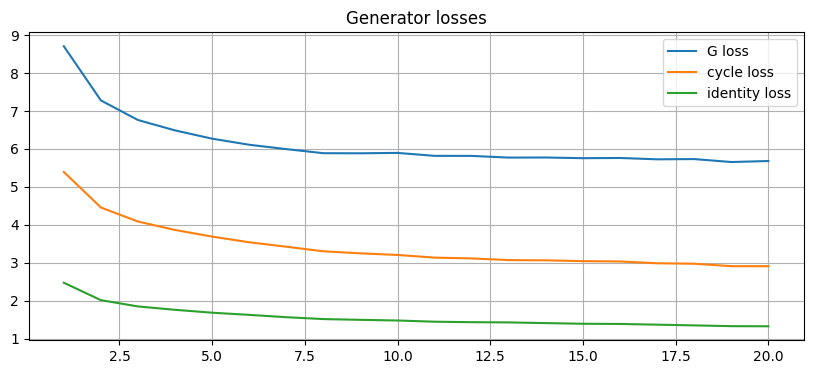

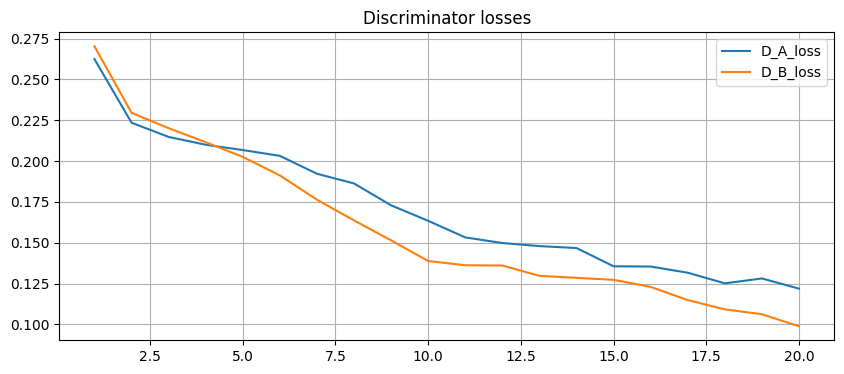

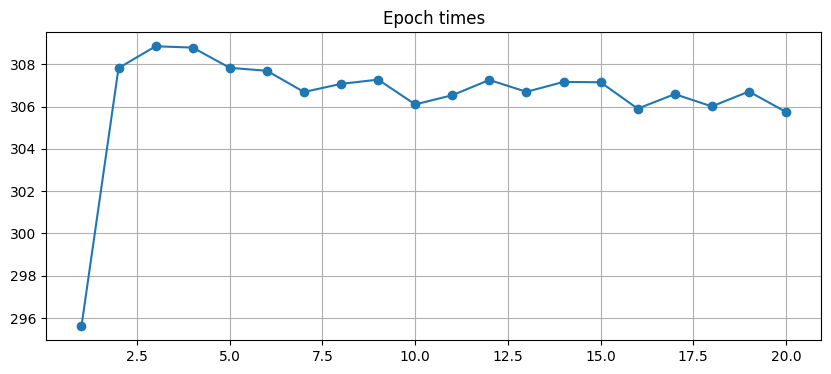

C:\Users\Master Arian\AppData\Local\Temp\ipykernel_4576\3730412217.py:311: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  GA.load_state_dict(torch.load(f"G_AB_{dataset_name}_

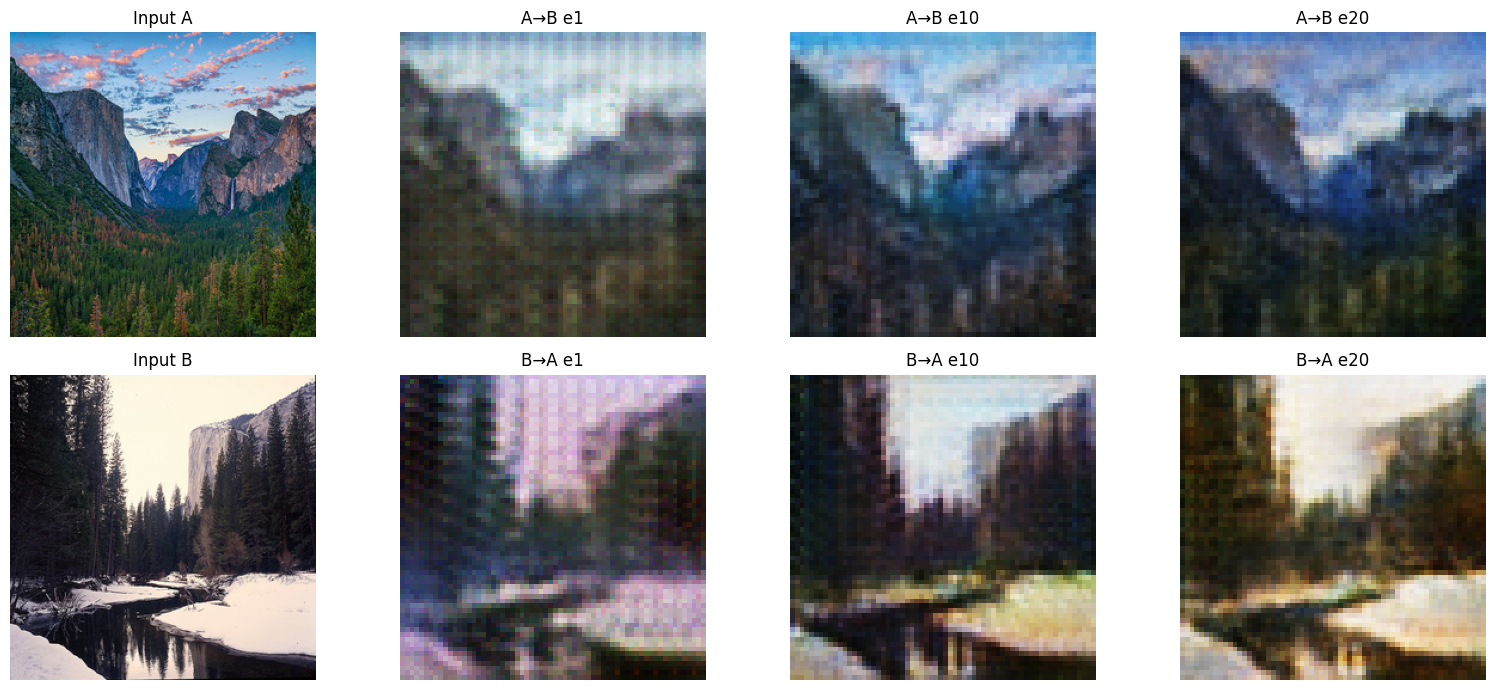

In [1]:
# ======================================================================
#                   FULL CYCLE-GAN PIPELINE (ONE CELL)
# ======================================================================

import os, random, time
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------------
#                 CONFIGURATION
# -----------------------------------------------------------

dataset_name = "summer2winter_yosemite"     #
base_root = r"C:/Users/Master Arian/Desktop/DGM2"

root = os.path.join(base_root, dataset_name)
trainA_dir = os.path.join(root, "trainA")
trainB_dir = os.path.join(root, "trainB")
testA_dir  = os.path.join(root, "testA")
testB_dir  = os.path.join(root, "testB")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

img_size = 64
batch_size = 1

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

# -----------------------------------------------------------
#                 DATASET CLASS
# -----------------------------------------------------------

class UnpairedDataset(Dataset):
    def __init__(self, dir_A, dir_B, transform=None):
        self.dir_A = dir_A
        self.dir_B = dir_B
        self.transform = transform

        self.A = [f for f in os.listdir(dir_A) if f.endswith(("jpg","png","jpeg"))]
        self.B = [f for f in os.listdir(dir_B) if f.endswith(("jpg","png","jpeg"))]

        self.lenA = len(self.A)
        self.lenB = len(self.B)

    def __len__(self):
        return max(self.lenA, self.lenB)

    def __getitem__(self, idx):
        fileA = self.A[idx % self.lenA]
        fileB = random.choice(self.B)

        imgA = Image.open(os.path.join(self.dir_A, fileA)).convert("RGB")
        imgB = Image.open(os.path.join(self.dir_B, fileB)).convert("RGB")

        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)

        return imgA, imgB

train_loader = DataLoader(
    UnpairedDataset(trainA_dir, trainB_dir, transform),
    batch_size=batch_size, shuffle=True, num_workers=0
)

print("Training batches:", len(train_loader))

# -----------------------------------------------------------
#              GENERATOR ARCHITECTURE
# -----------------------------------------------------------

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x): return x + self.block(x)

class ResnetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_res=6):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True)
        ]

        in_f, out_f = 64, 128
        for _ in range(2):
            model += [
                nn.Conv2d(in_f, out_f, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_f),
                nn.ReLU(True)
            ]
            in_f = out_f
            out_f *= 2

        for _ in range(n_res):
            model += [ResidualBlock(in_f)]

        out_f = in_f // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_f, out_f, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_f),
                nn.ReLU(True),
            ]
            in_f = out_f
            out_f //= 2

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# -----------------------------------------------------------
#              DISCRIMINATOR (PatchGAN 70×70)
# -----------------------------------------------------------

class PatchDiscriminator(nn.Module):
    def __init__(self, in_c=3):
        super().__init__()
        def C(i, o, norm=True):
            layers = [nn.Conv2d(i,o,4,2,1), nn.LeakyReLU(0.2)]
            if norm: layers.insert(1, nn.InstanceNorm2d(o))
            return layers
        self.model = nn.Sequential(
            *C(in_c, 64, norm=False),
            *C(64, 128),
            *C(128, 256),
            nn.Conv2d(256, 512,4,1,1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512,1,4,1,1)
        )
    def forward(self, x): return self.model(x)

# -----------------------------------------------------------
#                INITIALIZATION
# -----------------------------------------------------------

n_res_blocks = 6 if img_size==128 else 9

G_AB = ResnetGenerator(n_res=n_res_blocks).to(device)
G_BA = ResnetGenerator(n_res=n_res_blocks).to(device)
D_A  = PatchDiscriminator().to(device)
D_B  = PatchDiscriminator().to(device)

criterion_gan = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_id = nn.L1Loss()

def real_label_like(pred): return torch.ones_like(pred)
def fake_label_like(pred): return torch.zeros_like(pred)

# Optimizers
lr=0.0002
opt_G   = optim.Adam(list(G_AB.parameters())+list(G_BA.parameters()), lr=lr, betas=(0.5,0.999))
opt_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(0.5,0.999))
opt_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(0.5,0.999))

# -----------------------------------------------------------
#                      TRAIN LOOP
# -----------------------------------------------------------

num_epochs = 20

G_losses=[]; D_A_losses=[]; D_B_losses=[]
cycle_losses=[]; id_losses=[]; epoch_times=[]

for epoch in range(1, num_epochs+1):
    start = time.time()
    G_l=D_A_l=D_B_l=cy_l=id_l = 0

    for realA, realB in train_loader:
        realA = realA.to(device)
        realB = realB.to(device)

        # ---------- TRAIN GENERATORS ----------
        opt_G.zero_grad()

        idA = G_BA(realA)
        idB = G_AB(realB)
        loss_id = 5 * (criterion_id(idA, realA) + criterion_id(idB, realB))

        fakeB = G_AB(realA)
        fakeA = G_BA(realB)

        loss_gan_AB = criterion_gan(D_B(fakeB), real_label_like(D_B(fakeB)))
        loss_gan_BA = criterion_gan(D_A(fakeA), real_label_like(D_A(fakeA)))

        recA = G_BA(fakeB)
        recB = G_AB(fakeA)
        loss_cycle = 10 * (criterion_cycle(recA, realA) + criterion_cycle(recB, realB))

        loss_G = loss_id + loss_gan_AB + loss_gan_BA + loss_cycle
        loss_G.backward()
        opt_G.step()

        # ---------- TRAIN D_A ----------
        opt_D_A.zero_grad()
        loss_DA = (criterion_gan(D_A(realA), real_label_like(D_A(realA))) +
                   criterion_gan(D_A(fakeA.detach()), fake_label_like(D_A(fakeA.detach())))) * 0.5
        loss_DA.backward()
        opt_D_A.step()

        # ---------- TRAIN D_B ----------
        opt_D_B.zero_grad()
        loss_DB = (criterion_gan(D_B(realB), real_label_like(D_B(realB))) +
                   criterion_gan(D_B(fakeB.detach()), fake_label_like(D_B(fakeB.detach())))) * 0.5
        loss_DB.backward()
        opt_D_B.step()

        # Accumulate
        G_l+=loss_G.item(); D_A_l+=loss_DA.item(); D_B_l+=loss_DB.item()
        cy_l+=loss_cycle.item(); id_l+=loss_id.item()

    # Epoch end
    n=len(train_loader)
    G_losses.append(G_l/n); D_A_losses.append(D_A_l/n); D_B_losses.append(D_B_l/n)
    cycle_losses.append(cy_l/n); id_losses.append(id_l/n)
    epoch_times.append(time.time()-start)

    print(f"Epoch {epoch:02d}/{num_epochs} | "
          f"G={G_losses[-1]:.3f} | D_A={D_A_losses[-1]:.3f} | D_B={D_B_losses[-1]:.3f} | "
          f"cycle={cycle_losses[-1]:.3f} | id={id_losses[-1]:.3f} | "
          f"time={epoch_times[-1]:.1f}s")

    if epoch in [1,10,20]:
        torch.save(G_AB.state_dict(), f"G_AB_{dataset_name}_epoch{epoch}.pth")
        torch.save(G_BA.state_dict(), f"G_BA_{dataset_name}_epoch{epoch}.pth")

torch.save(G_AB.state_dict(), f"G_AB_{dataset_name}_final.pth")
torch.save(G_BA.state_dict(), f"G_BA_{dataset_name}_final.pth")

print("Total training time:", sum(epoch_times)/60, "minutes")

# -----------------------------------------------------------
#                     PLOT LOSSES
# -----------------------------------------------------------

e = np.arange(1,num_epochs+1)

plt.figure(figsize=(10,4))
plt.plot(e,G_losses,label="G loss")
plt.plot(e,cycle_losses,label="cycle loss")
plt.plot(e,id_losses,label="identity loss")
plt.legend(); plt.grid(); plt.title("Generator losses"); plt.show()

plt.figure(figsize=(10,4))
plt.plot(e,D_A_losses,label="D_A_loss")
plt.plot(e,D_B_losses,label="D_B_loss")
plt.legend(); plt.grid(); plt.title("Discriminator losses"); plt.show()

plt.figure(figsize=(10,4))
plt.plot(e,epoch_times, marker='o')
plt.title("Epoch times"); plt.grid(); plt.show()

# -----------------------------------------------------------
#       SHOW SAMPLE OUTPUTS FOR EPOCHS 1,10,20
# -----------------------------------------------------------

def load_img(folder):
    file = random.choice([f for f in os.listdir(folder) if f.endswith(("jpg","png","jpeg"))])
    imgPIL = Image.open(os.path.join(folder,file)).convert("RGB")
    t = transform(imgPIL).unsqueeze(0).to(device)
    return imgPIL, t

imgA_pil, imgA = load_img(testA_dir)
imgB_pil, imgB = load_img(testB_dir)

to_img = transforms.Compose([
    transforms.Normalize((0,0,0),(1/0.5,1/0.5,1/0.5)),
    transforms.Normalize((-0.5,-0.5,-0.5),(1,1,1))
])

def t2np(t): return to_img(t).clamp(0,1).permute(1,2,0).cpu().numpy()

epochs_show=[1,10,20]
fig,ax=plt.subplots(2,4,figsize=(16,7))

ax[0,0].imshow(np.array(imgA_pil)); ax[0,0].set_title("Input A"); ax[0,0].axis("off")
ax[1,0].imshow(np.array(imgB_pil)); ax[1,0].set_title("Input B"); ax[1,0].axis("off")

for j,ep in enumerate(epochs_show):
    GA=ResnetGenerator(n_res=n_res_blocks).to(device)
    GB=ResnetGenerator(n_res=n_res_blocks).to(device)
    GA.load_state_dict(torch.load(f"G_AB_{dataset_name}_epoch{ep}.pth", map_location=device))
    GB.load_state_dict(torch.load(f"G_BA_{dataset_name}_epoch{ep}.pth", map_location=device))
    GA.eval(); GB.eval()

    with torch.no_grad():
        fb = GA(imgA); fa = GB(imgB)

    ax[0,j+1].imshow(t2np(fb[0])); ax[0,j+1].set_title(f"A→B e{ep}"); ax[0,j+1].axis("off")    
    ax[1,j+1].imshow(t2np(fa[0])); ax[1,j+1].set_title(f"B→A e{ep}"); ax[1,j+1].axis("off")

plt.tight_layout(); plt.show()

# ======================================================================
#                               END
# ======================================================================
